### Import Libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import os

import sys
from bs4 import BeautifulSoup
import re
import unicodedata

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 15)

### Set API URLs

In [2]:
spacex_url = "https://api.spacexdata.com/v4/launches/past"
booster_url = "https://api.spacexdata.com/v4/rockets/"
launchsite_url = "https://api.spacexdata.com/v4/launchpads/"
payload_url = "https://api.spacexdata.com/v4/payloads/"
cores_url = "https://api.spacexdata.com/v4/cores/"

### Set up functions

In [3]:
def get_spacex_data(url):
    response = requests.get(url)

    # Check the status code of the response
    if response.status_code != 200:
        raise ValueError("Failed to retrieve data: {}".format(response.status_code))

    # Get the JSON data from the response
    data = response.json()

    # Normalize the data and convert it to a Pandas DataFrame
    df = pd.json_normalize(data)

    return df


# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data["rocket"]:
        if x:
            response = requests.get(booster_url + str(x)).json()
            BoosterVersion.append(response["name"])


# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data["launchpad"]:
        if x:
            response = requests.get(launchsite_url + str(x)).json()
            Longitude.append(response["longitude"])
            Latitude.append(response["latitude"])
            LaunchSite.append(response["name"])


# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data["payloads"]:
        if load:
            response = requests.get(payload_url + load)
            payload_data = response.json()
            PayloadMass.append(payload_data["mass_kg"])
            Orbit.append(payload_data["orbit"])


# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data["cores"]:
        if core["core"] != None:
            response = requests.get(cores_url + core["core"]).json()
            Block.append(response["block"])
            ReusedCount.append(response["reuse_count"])
            Serial.append(response["serial"])
        else:
            Block.append(None)
            ReusedCount.append(None)
            Serial.append(None)
        Outcome.append(str(core["landing_success"]) + " " + str(core["landing_type"]))
        Flights.append(core["flight"])
        GridFins.append(core["gridfins"])
        Reused.append(core["reused"])
        Legs.append(core["legs"])
        LandingPad.append(core["landpad"])
        
def get_list_length(x):
    return len(x)


def get_first_element(x):
    return x[0]

In [4]:
spacex_df = get_spacex_data(spacex_url)

In [5]:
spacex_df.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T...,1.142554e+09,False,0.0,5e9d0d95eda...,False,[{'time': 3...,Engine fail...,[],[],[],[5eb0e4b5b6...,5e9e4502f50...,1,FalconSat,2006-03-24T...,1143239400,2006-03-25T...,hour,False,[{'core': '...,True,False,None,5eb87cd9ffd...,False,False,False,[],https://ima...,https://ima...,None,None,None,None,[],[],None,https://www...,0a_00nJ_Y88,https://www...,https://en....,NaN
1,None,NaN,False,0.0,5e9d0d95eda...,False,[{'time': 3...,Successful ...,[],[],[],[5eb0e4b6b6...,5e9e4502f50...,2,DemoSat,2007-03-21T...,1174439400,2007-03-21T...,hour,False,[{'core': '...,True,False,None,5eb87cdaffd...,False,False,False,[],https://ima...,https://ima...,None,None,None,None,[],[],None,https://www...,Lk4zQ2wP-Nc,https://www...,https://en....,NaN
2,None,NaN,False,0.0,5e9d0d95eda...,False,[{'time': 1...,Residual st...,[],[],[],[5eb0e4b6b6...,5e9e4502f50...,3,Trailblazer,2008-08-03T...,1217734440,2008-08-03T...,hour,False,[{'core': '...,True,False,None,5eb87cdbffd...,False,False,False,[],https://ima...,https://ima...,None,None,None,None,[],[],None,https://www...,v0w9p3U8860,http://www....,https://en....,NaN
3,2008-09-20T...,1.221869e+09,False,0.0,5e9d0d95eda...,True,[],Ratsat was ...,[],[],[],[5eb0e4b7b6...,5e9e4502f50...,4,RatSat,2008-09-28T...,1222643700,2008-09-28T...,hour,False,[{'core': '...,True,False,None,5eb87cdbffd...,False,False,False,[],https://ima...,https://ima...,None,None,None,None,[],[],None,https://www...,dLQ2tZEH6G0,https://en....,https://en....,NaN
4,None,NaN,False,0.0,5e9d0d95eda...,True,[],None,[],[],[],[5eb0e4b7b6...,5e9e4502f50...,5,RazakSat,2009-07-13T...,1247456100,2009-07-13T...,hour,False,[{'core': '...,True,False,None,5eb87cdcffd...,False,False,False,[],https://ima...,https://ima...,None,None,None,None,[],[],http://www....,https://www...,yTaIDooc8Og,http://www....,https://en....,NaN


In [6]:
spacex_df = spacex_df[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]
spacex_df.head(3)

,rocket,payloads,launchpad,cores,flight_number,date_utc
0,5e9d0d95eda...,[5eb0e4b5b6...,5e9e4502f50...,[{'core': '...,1,2006-03-24T...
1,5e9d0d95eda...,[5eb0e4b6b6...,5e9e4502f50...,[{'core': '...,2,2007-03-21T...
2,5e9d0d95eda...,[5eb0e4b6b6...,5e9e4502f50...,[{'core': '...,3,2008-08-03T...


In [7]:
spacex_df = spacex_df[spacex_df["cores"].apply(get_list_length) == 1]
spacex_df = spacex_df[spacex_df["payloads"].apply(get_list_length) == 1]
spacex_df["cores"] = spacex_df["cores"].apply(get_first_element)
spacex_df["payloads"] = spacex_df["payloads"].apply(get_first_element)

spacex_df["date"] = pd.to_datetime(spacex_df["date_utc"]).dt.date
spacex_df = spacex_df.loc[spacex_df["date"] <= datetime.date(2020, 11, 13)]

In [8]:
spacex_df.shape

(94, 7)

In [9]:
# Global vars
BoosterVersion, PayloadMass, Orbit, LaunchSite, Outcome, Flights, GridFins, Reused, Legs, LandingPad, \
Block, ReusedCount, Serial, Longitude, Latitude = [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

In [10]:
getBoosterVersion(spacex_df)
getLaunchSite(spacex_df)
getPayloadData(spacex_df)
getCoreData(spacex_df)

In [11]:
launch_dict = {
    "FlightNumber": list(spacex_df["flight_number"]),
    "Date": list(spacex_df["date"]),
    "BoosterVersion": BoosterVersion,
    "PayloadMass": PayloadMass,
    "Orbit": Orbit,
    "LaunchSite": LaunchSite,
    "Outcome": Outcome,
    "Flights": Flights,
    "GridFins": GridFins,
    "Reused": Reused,
    "Legs": Legs,
    "LandingPad": LandingPad,
    "Block": Block,
    "ReusedCount": ReusedCount,
    "Serial": Serial,
    "Longitude": Longitude,
    "Latitude": Latitude,
}

In [12]:
column_order = ['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit', 'LaunchSite', 'Outcome', 'Flights', 
                'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude', 'Latitude']

df = pd.DataFrame(launch_dict, columns = column_order)

In [13]:
len(BoosterVersion)

94

In [14]:
lengths = [len(launch_dict[key]) for key in launch_dict]

print(lengths)

[94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94]


In [15]:
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein A...,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein A...,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein A...,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein A...,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [16]:
data_falcon9 = df[df["BoosterVersion"] != "Falcon 1"]
data_falcon9.shape

(90, 17)

In [17]:
data_falcon9.loc[:, "FlightNumber"] = list(range(1, data_falcon9.shape[0] + 1))
data_falcon9.reset_index(drop=True, inplace=True)
data_falcon9.head()

C:\Users\flori\AppData\Local\Temp\ipykernel_2900\102212020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9.loc[:, "FlightNumber"] = list(range(1, data_falcon9.shape[0] + 1))


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


### Data wrangle

In [18]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [19]:
mean_payload_mass = data_falcon9['PayloadMass'].mean()
mean_payload_mass

6123.547647058824

In [20]:
data_falcon9.loc[:,'PayloadMass'] = data_falcon9.loc[:,'PayloadMass'].fillna(mean_payload_mass)

C:\Users\flori\AppData\Local\Temp\ipykernel_2900\2407153349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9.loc[:,'PayloadMass'] = data_falcon9.loc[:,'PayloadMass'].fillna(mean_payload_mass)


In [21]:
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


### Scrape more data

In [22]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    column_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(column_name.strip().isdigit()):
        column_name = column_name.strip()
        return column_name    

In [23]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

In [24]:
response = requests.get(static_url)
wiki = response.content
soup = BeautifulSoup(wiki, "html.parser")

In [25]:
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

In [26]:
html_tables = soup.find_all('table')

In [27]:
# Initialize empty list to store launch dictionaries
launches = []

# Extract each table
for table_number, table in enumerate(
    soup.find_all("table", "wikitable plainrowheaders collapsible")
):
    # get table row
    for rows in table.find_all("tr"):
        # check to see if first table heading is as number corresponding to launch a number
        if rows.th:
            if rows.th.string:
                flight_number = rows.th.string.strip()
                flag = flight_number.isdigit()
        else:
            flag = False
        # get table element
        row = rows.find_all("td")
        # if it is number save cells in a dictonary
        if flag:
            # Initialize empty dictionary to store data for this launch
            launch_dict = {}
            # Flight Number value
            launch_dict["Flight No."] = flight_number
            # Date value
            datatimelist = date_time(row[0])
            launch_dict["Date"] = datatimelist[0].strip(",")
            # Time value
            launch_dict["Time"] = datatimelist[1]
            # Booster version
            bv = booster_version(row[1])
            if not (bv):
                bv = row[1].a.string
            launch_dict["Version Booster"] = bv
            # Launch Site
            launch_dict["Launch Site"] = row[2].a.string
            # Payload
            launch_dict["Payload"] = row[3].a.string
            # Payload Mass
            launch_dict["Payload mass"] = get_mass(row[4])
            # Orbit
            launch_dict["Orbit"] = row[5].a.string
            # Customer
            launch_dict["Customer"] = row[6].get_text()
            # Launch outcome
            launch_dict["Launch outcome"] = list(row[7].strings)[0]
            # Booster landing
            launch_dict["Booster landing"] = landing_status(row[8])
            # Append launch dictionary to list of launches
            launches.append(launch_dict)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(launches)
df.head(5)

,Flight No.,Date,Time,Version Booster,Launch Site,Payload,Payload mass,Orbit,Customer,Launch outcome,Booster landing
0,1,4 June 2010,18:45,F9 v1.0,CCAFS,Dragon Spac...,0,LEO,SpaceX\n,Success\n,"[Failure, [..."
1,2,8 December ...,15:43,F9 v1.0,CCAFS,Dragon,0,LEO,\nNASA (COT...,Success,"[Failure, [..."
2,3,22 May 2012,07:44,F9 v1.0,CCAFS,Dragon,525 kg,LEO,NASA (COTS)\n,Success,[No attempt\n]
3,4,8 October 2012,00:35,F9 v1.0,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA (CRS)\n,Success\n,[No attempt...
4,5,1 March 2013,15:10,F9 v1.0,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA (CRS)\n,Success\n,[No attempt\n]


In [28]:
import re

def clean_string(string):
    # Check if input is a list
    if isinstance(string, list):
        # Join list elements with a space character
        string = ' '.join(string)
    # Check if string is None
    if string is not None:
        # Remove text within square brackets
        string = re.sub(r'\[.*?\]', '', string)
        # Remove double and 7 space characters
        string = re.sub(r' {2,7}', ' ', string)
        # Remove newline characters
        string = string.replace('\n', ' ')
        # Remove leading and trailing whitespace characters
        string = string.strip()
    return string

# Clean up the 'Launch outcome', 'Booster landing', and 'Customer' columns
df['Launch outcome'] = df['Launch outcome'].apply(clean_string)
df['Booster landing'] = df['Booster landing'].apply(clean_string)
df['Customer'] = df['Customer'].apply(clean_string)

In [29]:
pd.set_option('display.max_colwidth', 55)
df.tail()

,Flight No.,Date,Time,Version Booster,Launch Site,Payload,Payload mass,Orbit,Customer,Launch outcome,Booster landing
116,117,9 May 2021,06:42,F9 B5,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success,Success (drone ship)
117,118,15 May 2021,22:56,F9 B5,KSC,Starlink,"~14,000 kg",LEO,SpaceX Capella Space and Tyvak,Success,Success (drone ship)
118,119,26 May 2021,18:59,F9 B5,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success,Success (drone ship)
119,120,3 June 2021,17:29,F9 B5,KSC,SpaceX CRS-22,"3,328 kg",LEO,NASA (CRS),Success,Success (drone ship)
120,121,6 June 2021,04:26,F9 B5,CCSFS,SXM-8,"7,000 kg",GTO,Sirius XM,Success,Success (drone ship)


In [30]:
df.isnull().sum()

Flight No.         0
Date               0
Time               0
Version Booster    0
Launch Site        0
Payload            0
Payload mass       0
Orbit              0
Customer           0
Launch outcome     0
Booster landing    0
dtype: int64

In [31]:
df['Booster landing'].value_counts()

Success (drone ship)      64
No attempt                22
Success (ground pad)      16
Failure (drone ship)       8
Controlled (ocean)         5
Failure (parachute)        2
Uncontrolled (ocean)       2
Precluded (drone ship)     1
Failure (ground pad)       1
Name: Booster landing, dtype: int64

In [32]:
df.head()

,Flight No.,Date,Time,Version Booster,Launch Site,Payload,Payload mass,Orbit,Customer,Launch outcome,Booster landing
0,1,4 June 2010,18:45,F9 v1.0,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
1,2,8 December 2010,15:43,F9 v1.0,CCAFS,Dragon,0,LEO,NASA (COTS) NRO,Success,Failure (parachute)
2,3,22 May 2012,07:44,F9 v1.0,CCAFS,Dragon,525 kg,LEO,NASA (COTS),Success,No attempt
3,4,8 October 2012,00:35,F9 v1.0,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA (CRS),Success,No attempt
4,5,1 March 2013,15:10,F9 v1.0,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA (CRS),Success,No attempt


### More wrangling on the scraped data set

In [33]:
df['Version Booster'] = df['Version Booster'].str.replace('♺', '')

df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%d-%m-%Y')

df['Time'] = pd.to_datetime(df['Time'])
df['Time'] = df['Time'].dt.strftime('%H:%M')


def extract_range(s):
    numbers = s.split('–')
    if len(numbers) == 2:
        return (int(numbers[0]) + int(numbers[1])) / 2
    else:
        return s

df['Payload mass'] = df['Payload mass'].astype(str)
df['Payload mass'] = df['Payload mass'].str.replace(' kg','').str.replace(',','').str.replace('C', '0').str.replace('~','')
df['Payload mass'] = df['Payload mass'].apply(extract_range)
df['Payload mass'] = pd.to_numeric(df['Payload mass'])

df.head()

,Flight No.,Date,Time,Version Booster,Launch Site,Payload,Payload mass,Orbit,Customer,Launch outcome,Booster landing
0,1,04-06-2010,18:45,F9 v1.0,CCAFS,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Success,Failure (parachute)
1,2,08-12-2010,15:43,F9 v1.0,CCAFS,Dragon,0.0,LEO,NASA (COTS) NRO,Success,Failure (parachute)
2,3,22-05-2012,07:44,F9 v1.0,CCAFS,Dragon,525.0,LEO,NASA (COTS),Success,No attempt
3,4,08-10-2012,00:35,F9 v1.0,CCAFS,SpaceX CRS-1,4700.0,LEO,NASA (CRS),Success,No attempt
4,5,01-03-2013,15:10,F9 v1.0,CCAFS,SpaceX CRS-2,4877.0,LEO,NASA (CRS),Success,No attempt


In [34]:
df.to_csv('spacex_web_scraped.csv', index=False)

In [35]:
df_web = df.copy()
df_web.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Flight No.       121 non-null    object 
 1   Date             121 non-null    object 
 2   Time             121 non-null    object 
 3   Version Booster  121 non-null    object 
 4   Launch Site      121 non-null    object 
 5   Payload          121 non-null    object 
 6   Payload mass     121 non-null    float64
 7   Orbit            121 non-null    object 
 8   Customer         121 non-null    object 
 9   Launch outcome   121 non-null    object 
 10  Booster landing  121 non-null    object 
dtypes: float64(1), object(10)
memory usage: 10.5+ KB


In [36]:
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [37]:
data_falcon9.isnull().sum() / data_falcon9.count()*100

FlightNumber       0.000
Date               0.000
BoosterVersion     0.000
PayloadMass        0.000
Orbit              0.000
LaunchSite         0.000
Outcome            0.000
Flights            0.000
GridFins           0.000
Reused             0.000
Legs               0.000
LandingPad        40.625
Block              0.000
ReusedCount        0.000
Serial             0.000
Longitude          0.000
Latitude           0.000
dtype: float64

In [38]:
data_falcon9.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [39]:
data_falcon9['LaunchSite'].value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

In [40]:
data_falcon9['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

In [41]:
landing_outcomes = data_falcon9['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

In [42]:
for i, outcome in enumerate(landing_outcomes.keys()):
    print(i, outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [43]:
bad_outcomes = set(landing_outcomes.keys()[[1, 3, 5, 6, 7]])
type(bad_outcomes)
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [44]:
data_falcon9['Class'] = np.where(data_falcon9['Outcome'].isin(bad_outcomes), 0, 1)
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


In [45]:
data_falcon9["Class"].value_counts()

1    60
0    30
Name: Class, dtype: int64

In [46]:
data_falcon9["Class"].mean()

0.6666666666666666

In [47]:
data_falcon9.to_csv("data_falcon9_part2.csv", index=False)

### Exploratory Data Analysis

In [49]:
%load_ext sql

In [141]:
# Enter the connection string for your Db2 on Cloud database instance below
# %sql ibm_db_sa://my-username:my-password@my-hostname:my-port/my-db-name?security=SSL
connection_string = f"ibm_db_sa://{DB2_USER}:{DB2_PASSWORD}@{DB2_HOSTNAME}:32304/bludb;security=SSL;"
%sql $connection_string
%config SqlMagic.displaycon = False

In [142]:
# or, just query for a specifc table that you want to verify exists in the database
%sql select * from SYSCAT.TABLES where TABNAME = 'SPACEXDATASET'

tabschema,tabname,owner,ownertype,TYPE,status,base_tabschema,base_tabname,rowtypeschema,rowtypename,create_time,alter_time,invalidate_time,stats_time,colcount,tableid,tbspaceid,card,npages,mpages,fpages,npartitions,nfiles,tablesize,overflow,tbspace,index_tbspace,long_tbspace,parents,children,selfrefs,keycolumns,keyindexid,keyunique,checkcount,datacapture,const_checked,pmap_id,partition_mode,log_attribute,pctfree,append_mode,REFRESH,refresh_time,LOCKSIZE,VOLATILE,row_format,property,statistics_profile,compression,rowcompmode,access_mode,clustered,active_blocks,droprule,maxfreespacesearch,avgcompressedrowsize,avgrowcompressionratio,avgrowsize,pctrowscompressed,logindexbuild,codepage,collationschema,collationname,collationschema_orderby,collationname_orderby,encoding_scheme,pctpagessaved,last_regen_time,secpolicyid,protectiongranularity,auditpolicyid,auditpolicyname,auditexceptionenabled,definer,oncommit,logged,onrollback,lastused,control,temporaltype,tableorg,extended_row_size,pctextendedrows,remarks
CQR66620,SPACEXDATASET,CQR66620,U,T,N,None,None,None,None,2023-01-08 12:51:14.507877,2023-01-08 12:51:14.507877,2023-01-08 12:51:14.507877,2023-01-08 12:51:38.508547,11,20,6339,121,1,0,2,-1,-1,-1,0,CQR66620SPACE1,None,None,0,0,0,0,0,0,0,N,YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY,1,,0,-1,N,,None,R,,N,,None,N,,F,None,0,N,999,0,0.0,123,0.0,None,1208,SYSIBM,IDENTITY,SYSIBM,IDENTITY,,0,2023-01-08 12:51:14.507877,0,,None,None,N,CQR66620,,,,2023-01-15,,N,R,N,-1.0,None


In [143]:
# Display the names of the unique launch sites  in the space mission

%sql select LAUNCH_SITE, COUNT(LAUNCH_SITE) Missions from SPACEXDATASET GROUP BY LAUNCH_SITE ORDER BY COUNT(LAUNCH_SITE) DESC

launch_site,missions
CCAFS,40
KSC,33
Cape Canaveral,20
VAFB,16
CCSFS,12


In [144]:
# Display 5 records where launch sites begin with the string 'CCA'

%sql select * from SPACEXDATASET WHERE LAUNCH_SITE LIKE 'CCA%' LIMIT 5

flight_no_,DATE,TIME,version_booster,launch_site,payload,payload_mass,orbit,customer,launch_outcome,booster_landing
1,2010-06-04,18:45:00,F9 v1.0,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2,2010-12-08,15:43:00,F9 v1.0,CCAFS,Dragon,0,LEO,NASA (COTS) NRO,Success,Failure (parachute)
3,2012-05-22,07:44:00,F9 v1.0,CCAFS,Dragon,525,LEO,NASA (COTS),Success,No attempt
4,2012-10-08,00:35:00,F9 v1.0,CCAFS,SpaceX CRS-1,4700,LEO,NASA (CRS),Success,No attempt
5,2013-03-01,15:10:00,F9 v1.0,CCAFS,SpaceX CRS-2,4877,LEO,NASA (CRS),Success,No attempt


In [145]:
# Display the total payload mass carried by boosters launched by NASA (CRS)

%sql select customer, sum(payload_mass) Total_Mass from SPACEXDATASET WHERE customer = 'NASA (CRS)' group by customer

customer,total_mass
NASA (CRS),59941


In [146]:
# Display average payload mass carried by booster version F9 v1.1

%sql select version_booster, avg(payload_mass) Avg_Mass from SPACEXDATASET WHERE version_booster = 'F9 v1.1' group by version_booster

version_booster,avg_mass
F9 v1.1,2534


In [147]:
# List the date when the first succesful landing outcome in ground pad was acheived.

%sql select min(date) Date from SPACEXDATASET WHERE launch_outcome = 'Success'

DATE
2010-06-04


In [148]:
# List the names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000

%sql select distinct(version_booster) from SPACEXDATASET WHERE payload_mass between 4000 and 6000 and booster_landing = 'Success (drone ship)' order by version_booster

version_booster
F9 B5
F9 FT


In [149]:
# List the total number of successful and failure mission outcomes

%sql select booster_landing, count(booster_landing) nr_succesful from SPACEXDATASET group by booster_landing ORDER BY count(booster_landing) DESC

booster_landing,nr_succesful
Success (drone ship),64
No attempt,22
Success (ground pad),16
Failure (drone ship),8
Controlled (ocean),5
Failure (parachute),2
Uncontrolled (ocean),2
Failure (ground pad),1
Precluded (drone ship),1


In [150]:
# List the   names of the booster_versions which have carried the maximum payload mass. Use a subquery
%sql select distinct(version_booster), count(version_booster) boosters_with_max from SPACEXDATASET \
where payload_mass in (select max(payload_mass) from SPACEXDATASET) group by version_booster

version_booster,boosters_with_max
F9 B5,24


In [151]:
# List the records which will display the month names, failure landing_outcomes in drone ship ,booster versions, launch_site for the months in year 2015.

%sql select DATE, MONTHNAME(DATE) as Month, version_booster, launch_site, booster_landing from SPACEXDATASET where YEAR(DATE) = '2015' and booster_landing = 'Failure (drone ship)'

DATE,MONTH,version_booster,launch_site,booster_landing
2015-01-10,January,F9 v1.1,Cape Canaveral,Failure (drone ship)
2015-04-14,April,F9 v1.1,Cape Canaveral,Failure (drone ship)


In [152]:
# Rank the  count of  successful landing_outcomes between the date 04-06-2010 and 20-03-2017 in descending order.
%sql select YEAR(DATE) as YEAR, count(launch_outcome) succesful_landings from SPACEXDATASET \
where (DATE between '2010-06-04' and '2017-03-20') and launch_outcome = 'Success' group by YEAR(DATE) order by count(launch_outcome) desc

YEAR,succesful_landings
2016,8
2014,6
2015,6
2013,3
2017,3
2010,2
2012,2


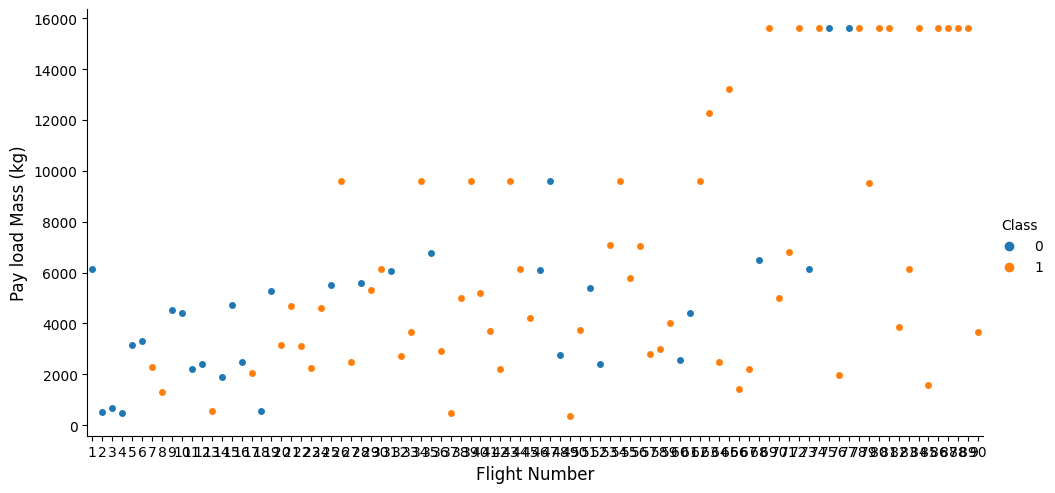

In [62]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=data_falcon9, aspect=2)
plt.xlabel("Flight Number", fontsize=12)
plt.ylabel("Pay load Mass (kg)", fontsize=12)
plt.show()

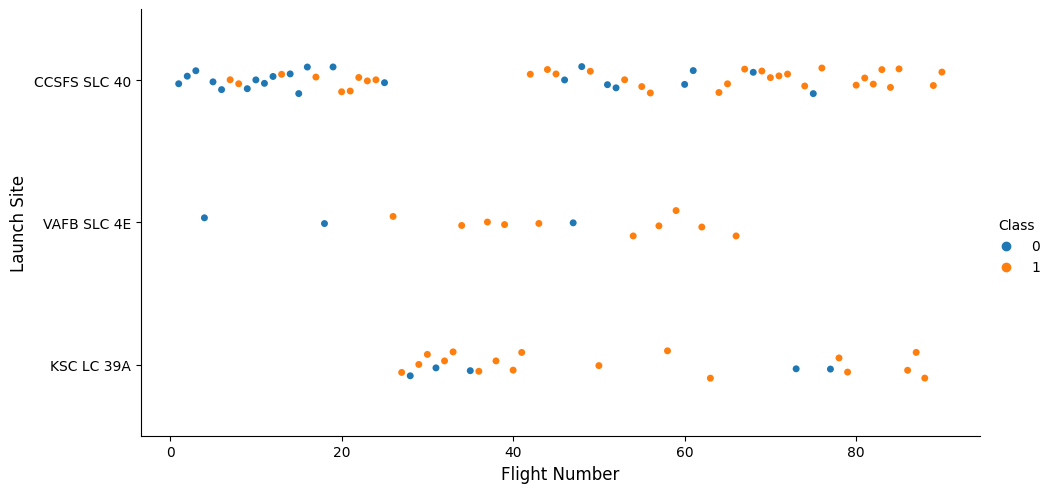

In [63]:
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=data_falcon9, aspect=2)
plt.xlabel("Flight Number", fontsize=12)
plt.ylabel("Launch Site", fontsize=12)
plt.show()

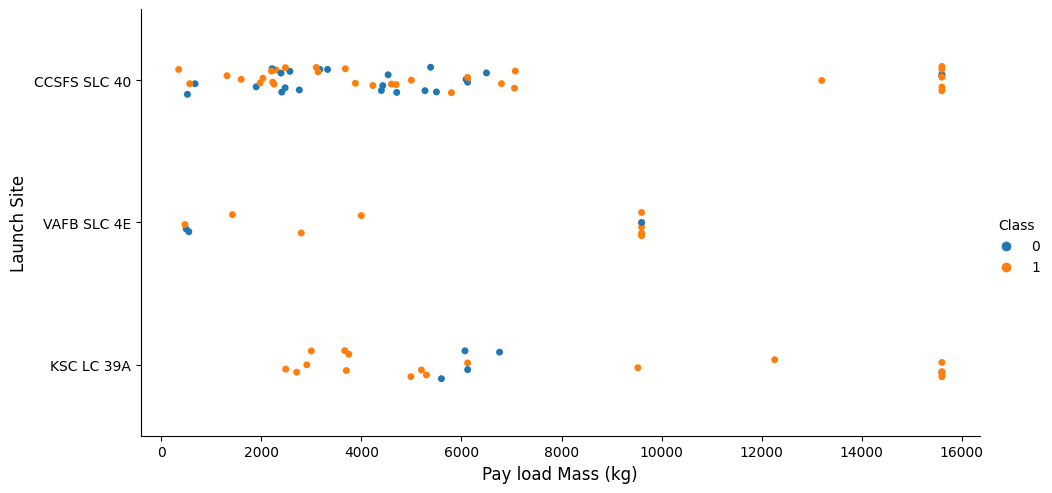

In [64]:
sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=data_falcon9, aspect=2)
plt.xlabel("Pay load Mass (kg)", fontsize=12)
plt.ylabel("Launch Site", fontsize=12)
plt.show()

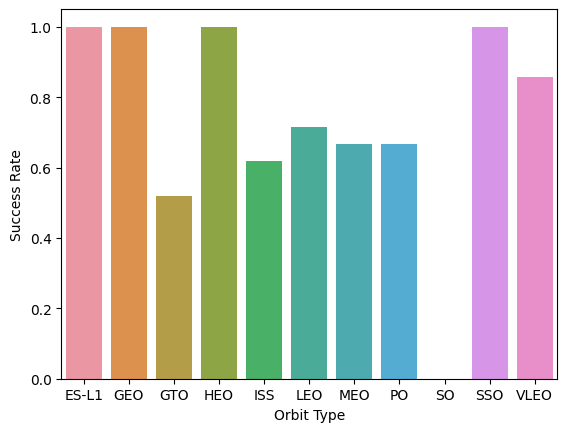

In [65]:
# Group data by Orbit and calculate mean success rate for each orbit type
orbit_success = data_falcon9.groupby('Orbit')['Class'].mean()

# Create bar chart
sns.barplot(x=orbit_success.index, y=orbit_success.values)

# Add labels to the axes
plt.xlabel("Orbit Type")
plt.ylabel("Success Rate")

# Show plot
plt.show()

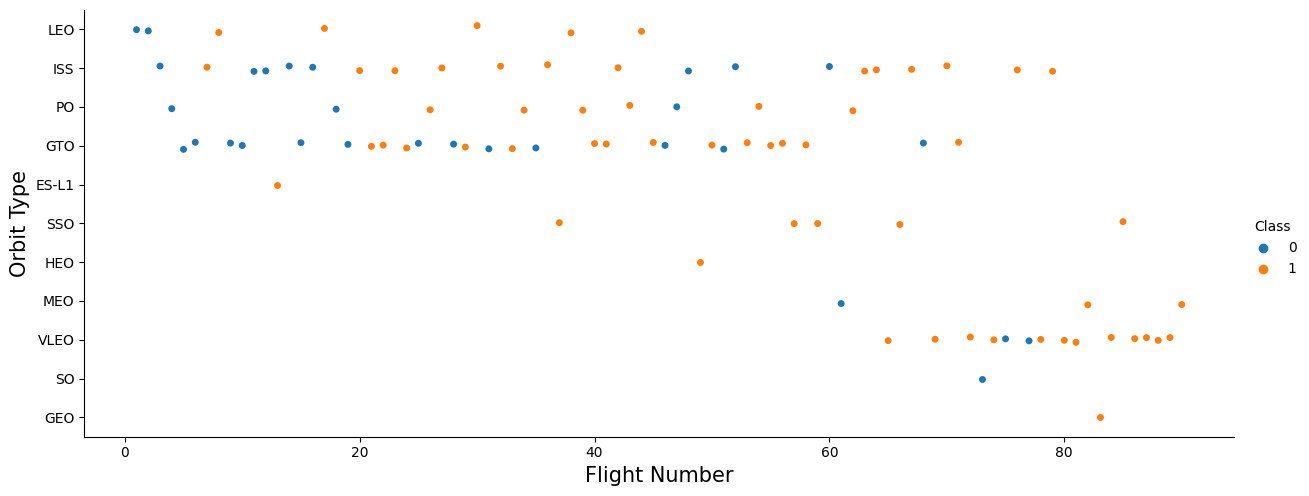

In [66]:
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=data_falcon9, aspect=2.5)
plt.xlabel("Flight Number", fontsize=15)
plt.ylabel("Orbit Type", fontsize=15)
plt.show()

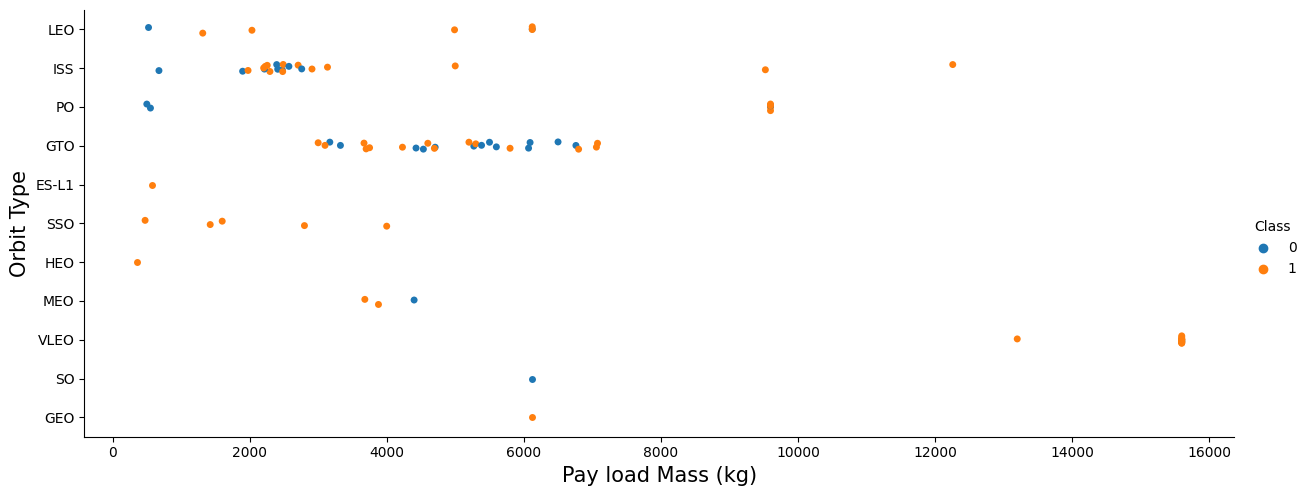

In [67]:
sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=data_falcon9, aspect=2.5)
plt.xlabel("Pay load Mass (kg)", fontsize=15)
plt.ylabel("Orbit Type", fontsize=15)
plt.show()

In [68]:
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


In [69]:
def Extract_year(date):
    years = []
    for d in date:
        years.append(d.year)
    return years

In [70]:
# Extract the year from the Date column
data_falcon9["Year"] = Extract_year(data_falcon9["Date"])
# Group the data by year
grouped = data_falcon9.groupby("Year")
# Calculate the success rate for each group
success_rate = grouped["Class"].mean()

In [71]:
success_rate

Year
2010    0.000000
2012    0.000000
2013    0.000000
2014    0.333333
2015    0.333333
2016    0.625000
2017    0.833333
2018    0.611111
2019    0.900000
2020    0.842105
Name: Class, dtype: float64

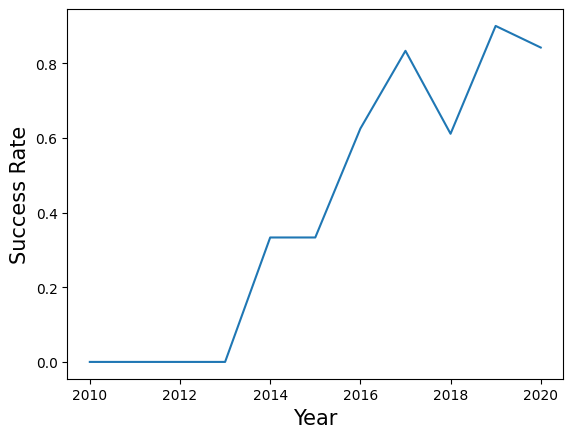

In [72]:
sns.lineplot(y=success_rate.values, x=success_rate.index)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Success Rate", fontsize=15)
plt.show()

### Features Engineering

In [73]:
features = data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


In [74]:
features_one_hot = pd.get_dummies(
    data=features,
    columns=[
        "Orbit",
        "LaunchSite",
        "LandingPad",
        "Serial",
        "GridFins",
        "Reused",
        "Legs",
    ],
)


In [75]:
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,...,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1,6123.547647,1,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
1,2,525.000000,1,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
2,3,677.000000,1,1.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,4,500.000000,1,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
4,5,3170.000000,1,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


In [76]:
features_one_hot = features_one_hot.astype('float64')
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,...,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6123.547647,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [77]:
features_one_hot.to_csv('features_one_hot_3.csv', index=False)

### Dashboards with Seaborn

In [78]:
dashy_df = data_falcon9.copy()
dashy_df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class,Year
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0,2010
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0,2012
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0,2013
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0,2013
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0,2013


In [79]:
dashy_df = dashy_df[
    [
        "FlightNumber",
        "LaunchSite",
        "PayloadMass",
        "Orbit",
        "Year",
        "BoosterVersion",
        "Class",
    ]
]
dashy_df.tail(5)

,FlightNumber,LaunchSite,PayloadMass,Orbit,Year,BoosterVersion,Class
85,86,KSC LC 39A,15600.0,VLEO,2020,Falcon 9,1
86,87,KSC LC 39A,15600.0,VLEO,2020,Falcon 9,1
87,88,KSC LC 39A,15600.0,VLEO,2020,Falcon 9,1
88,89,CCSFS SLC 40,15600.0,VLEO,2020,Falcon 9,1
89,90,CCSFS SLC 40,3681.0,MEO,2020,Falcon 9,1


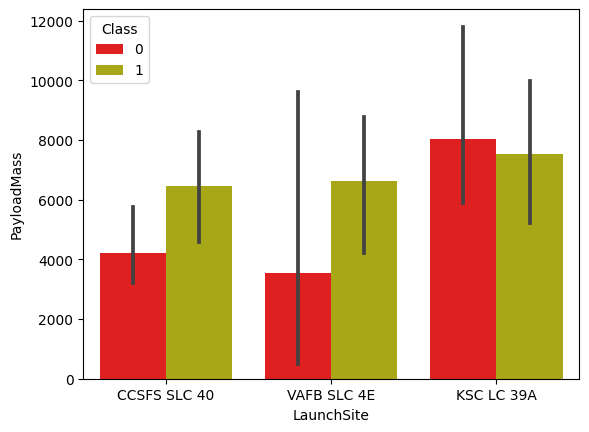

In [80]:
sns.barplot(x="LaunchSite", y="PayloadMass", hue="Class", palette=["r", "y"], data=dashy_df)
plt.show()

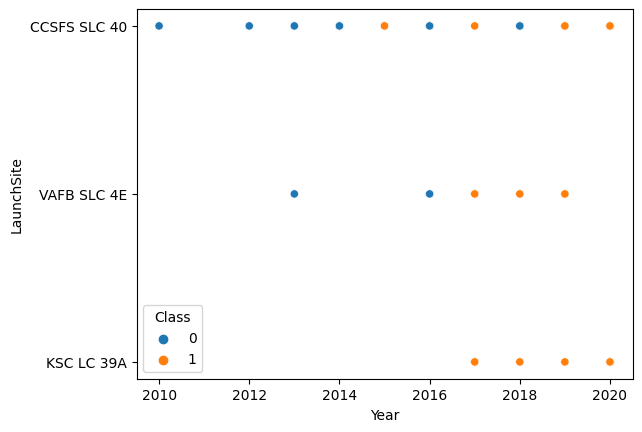

In [81]:
sns.scatterplot(x="Year", y="LaunchSite", hue="Class", data=dashy_df)
plt.show()

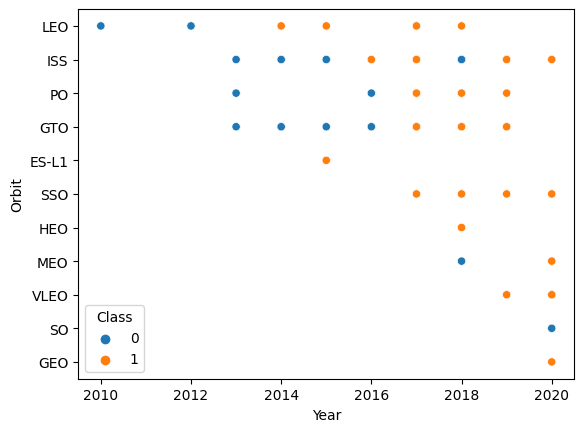

In [82]:
sns.scatterplot(x="Year", y="Orbit", hue="Class", data=dashy_df)
plt.show()

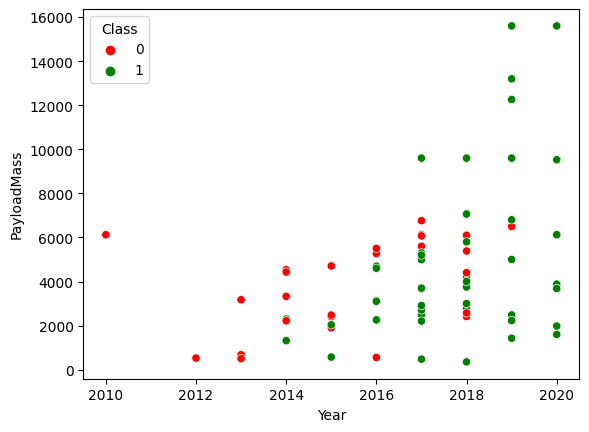

In [83]:
sns.scatterplot(x="Year", y="PayloadMass", hue="Class", palette=['r', 'g'], data=dashy_df)
plt.show()

In [84]:
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,...,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6123.547647,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


# Predictive Analysis (Classification)

In [85]:
def plot_confusion_matrix(y, y_predict):
    "this function plots the confusion matrix"

    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)
    # annot=True to annotate cells
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(["did not land", "land"])
    ax.yaxis.set_ticklabels(["did not land", "landed"])

In [112]:
# features_one_hot.columns

features_one_hot = pd.read_csv("features_one_hot_3_.csv", dtype='float')
data_falcon9 = pd.read_csv("data_falcon9_part2_.csv")

X = features_one_hot
y = data_falcon9['Class'].to_numpy()

##### Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).

##### Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.

In [113]:
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [114]:
X.shape
X

array([[-1.71291154,  0.        , -0.65391284, ..., -0.83553169,
         1.93309133, -1.93309133],
       [-1.67441914, -1.18972425, -0.65391284, ..., -0.83553169,
         1.93309133, -1.93309133],
       [-1.63592675, -1.15742336, -0.65391284, ..., -0.83553169,
         1.93309133, -1.93309133],
       ...,
       [ 1.63592675,  2.01380177,  3.49060516, ...,  1.19684269,
        -0.51730613,  0.51730613],
       [ 1.67441914,  2.01380177,  1.00389436, ...,  1.19684269,
        -0.51730613,  0.51730613],
       [ 1.71291154, -0.51905572, -0.65391284, ..., -0.83553169,
        -0.51730613,  0.51730613]])

##### We split the data into training and testing data using the function train_test_split. The training data is divided into validation data, a second set used for training data; then the models are trained and hyperparameters are selected using the function GridSearchCV.

Use the function train_test_split to split the data X and y into training and test data. Set the parameter test_size to 0.2 and random_state to 5. The training data and test data should be assigned to the following labels.

X_train, X_test, y_train, y_test

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((72, 83), (18, 83), (72,), (18,))

##### Create a logistic regression object then create a GridSearchCV object logreg_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.

In [116]:
parameters_lr = {"C": [0.01, 0.1, 1], "penalty": ["l2"], "solver": ["lbfgs"]}

lr = LogisticRegression()

In [117]:
logreg_cv = GridSearchCV(estimator = lr, param_grid = parameters_lr, cv=10)
logreg_cv.fit(X_train, y_train)

print("Tuned hyperparameters: (best parameters)", logreg_cv.best_params_)
print("Accuracy :", logreg_cv.best_score_)

Tuned hyperparameters: (best parameters) {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.8339285714285714


##### Calculate the accuracy on the test data using the method <code>score</code>:

In [118]:
accuracy_lr = logreg_cv.score(X_test, y_test)
print(accuracy_lr)

0.8888888888888888


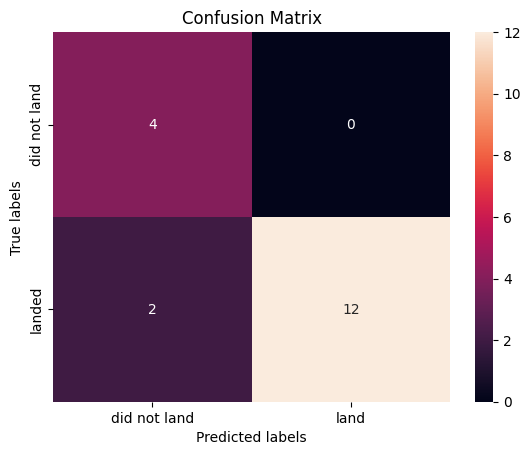

In [119]:
predict_lr = logreg_cv.predict(X_test)
plot_confusion_matrix(y_test, predict_lr)

#### Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [120]:
parameters_svm = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [121]:
svm_cv = GridSearchCV(estimator = svm, param_grid = parameters_svm, cv=10)
svm_cv.fit(X_train, y_train)

print("Tuned hyperparameters: (best parameters)", svm_cv.best_params_)
print("Accuracy :", svm_cv.best_score_)

Tuned hyperparameters: (best parameters) {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Accuracy : 0.8482142857142856


In [122]:
# evaluating the model on the test data using the best set of hyperparameters found by the grid search and returning the accuracy.

accuracy_svm = svm_cv.score(X_test, y_test)
print(accuracy_svm)

0.8888888888888888


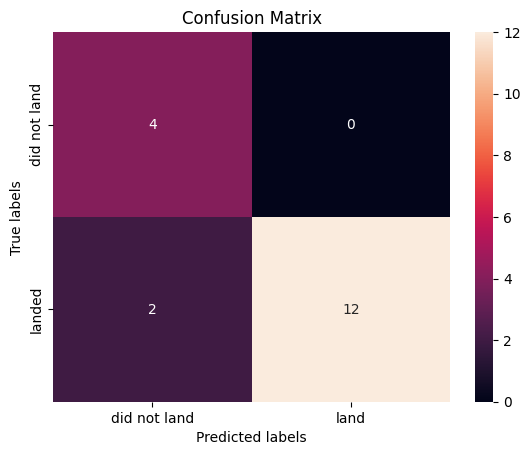

In [123]:
predict_svm = svm_cv.predict(X_test)
plot_confusion_matrix(y_test, predict_svm)

#### Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.

In [124]:
parameters_tree = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [125]:
tree_cv = GridSearchCV(estimator = tree, param_grid = parameters_tree, cv=10)
tree_cv.fit(X_train, y_train)

print("Tuned hyperparameters: (best parameters)", tree_cv.best_params_)
print("Accuracy :", tree_cv.best_score_)

Tuned hyperparameters: (best parameters) {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
Accuracy : 0.8785714285714284


In [126]:
# evaluating the model on the test data using the best set of hyperparameters found by the grid search and returning the accuracy.
accuracy_tree = tree_cv.score(X_test, y_test)
print(accuracy_tree)

0.8888888888888888


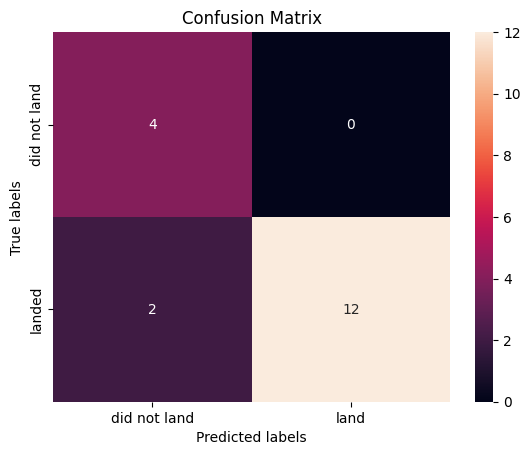

In [127]:
predict_tree = tree_cv.predict(X_test)
plot_confusion_matrix(y_test, predict_tree)

#### Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [128]:
parameters_knn = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [129]:
knn_cv = GridSearchCV(estimator = KNN, param_grid = parameters_knn, cv=10)
knn_cv.fit(X_train, y_train)

print("Tuned hyperparameters: (best parameters)", knn_cv.best_params_)
print("Accuracy :", knn_cv.best_score_)

Tuned hyperparameters: (best parameters) {'algorithm': 'auto', 'n_neighbors': 6, 'p': 1}
Accuracy : 0.8357142857142856


In [130]:
# evaluating the model on the test data using the best set of hyperparameters found by the grid search and returning the accuracy.

accuracy_KNN = knn_cv.score(X_test, y_test)
print(accuracy_KNN)

0.9444444444444444


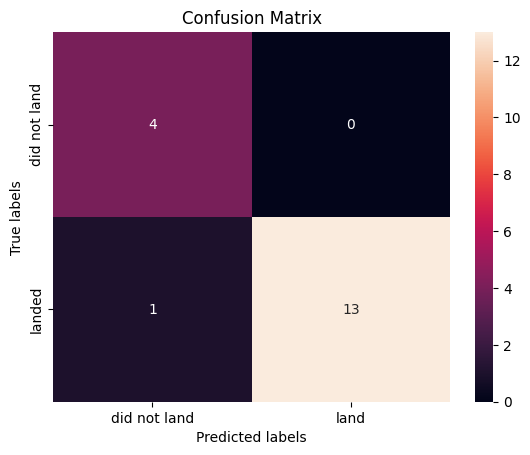

In [131]:
predict_KNN = knn_cv.predict(X_test)
plot_confusion_matrix(y_test, predict_KNN)

In [132]:
accuracy = {
    'LogisticRegression': accuracy_lr, 
    'SVM': accuracy_svm, 
    'DecisionTree': accuracy_tree,
    'KNN': accuracy_KNN
}
models_df = pd.DataFrame(list(accuracy.items()), columns = ['Model', 'Accuracy Test Data'])

In [133]:
models_df

,Model,Accuracy Test Data
0,LogisticRegression,0.888889
1,SVM,0.888889
2,DecisionTree,0.888889
3,KNN,0.944444


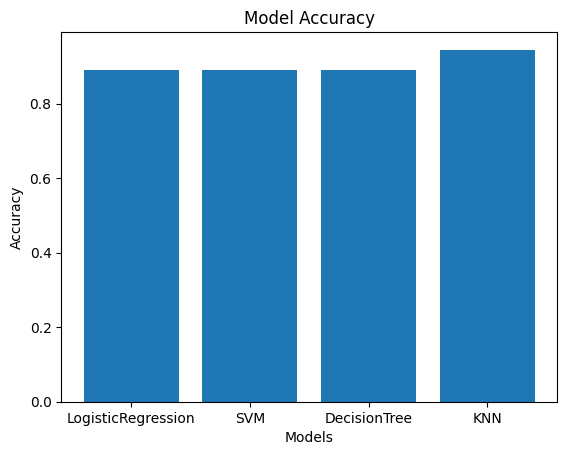

In [134]:
models = models_df['Model']
accuracy = models_df['Accuracy Test Data']

plt.bar(models, accuracy)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

#### Metrics

Precision: This is the number of true positives divided by the number of true positives plus false positives. It measures the proportion of positive predictions that are actually correct. High precision means that there are few false positives.

Recall (Sensitivity or TPR): This is the number of true positives divided by the number of true positives plus false negatives. It measures the proportion of actual positive observations that were correctly identified by the model. High recall means that there are few false negatives.

F1-score: This is the harmonic mean of precision and recall. It is a single metric that combines both precision and recall. High F1-score means that the precision and recall are both high.

ROC-AUC: It stands for receiver operating characteristic (ROC) curve and the area under the curve (AUC). It is a widely used metric that can be used to evaluate the performance of a binary classification model. The ROC-AUC measures the ability of the model to distinguish between the positive and negative classes. A model with a ROC-AUC of 1.0 is a perfect model, whereas a model with a ROC-AUC of 0.5 is a random model.

In [135]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Add columns to the models_df to store the metrics
models_df["Precision"] = None
models_df["Recall"] = None
models_df["F1-Score"] = None
models_df["ROC-AUC"] = None

predicts = [predict_lr, predict_svm, predict_tree, predict_KNN]
models = ["LogisticRegression", "SVM", "DecisionTree", "KNN"]

for i in range(len(models)):
    models_df.at[i, "Model"] = models[i]
    models_df.at[i, "Precision"] = precision_score(y_test, predicts[i])
    models_df.at[i, "Recall"] = recall_score(y_test, predicts[i])
    models_df.at[i, "F1-Score"] = f1_score(y_test, predicts[i])
    models_df.at[i, "ROC-AUC"] = roc_auc_score(y_test, predicts[i])

In [136]:
models_df

,Model,Accuracy Test Data,Precision,Recall,F1-Score,ROC-AUC
0,LogisticRegression,0.888889,1.0,0.857143,0.923077,0.928571
1,SVM,0.888889,1.0,0.857143,0.923077,0.928571
2,DecisionTree,0.888889,1.0,0.857143,0.923077,0.928571
3,KNN,0.944444,1.0,0.928571,0.962963,0.964286
